# An Introduction to Federated Learning with Flower

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

Let's start!

## Step 0: What is Flower ?

You can have a look on the Flower's [documentation](https://flower.dev/docs/), on the github [repository](https://github.com/adap/flower) (2.4k stars, 500 forks) or on the [paper](https://arxiv.org/pdf/2007.14390.pdf) released on arXiv. 

*Flower* is a FL framework that supports large-cohort training and evaluation, both on real edge devices and on single-node or multi-node compute clusters. This unlocks scalable algorithmic research of real-world system conditions such as limited computational resources which are common for typical FL workloads.

The team building it is dynamic and proposes a large variety of notebooks to get started with their framework!


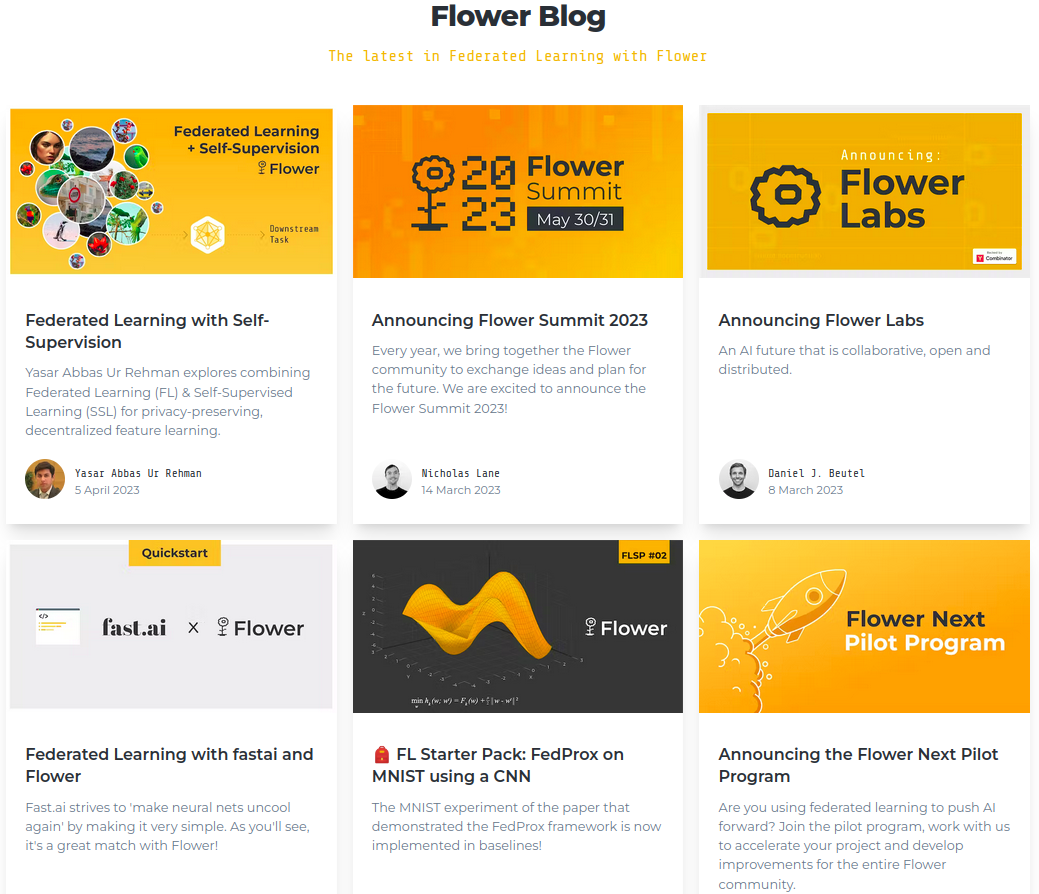

### Design goals 


1.   Scalable: Given that real-world FL would encounter a large number of clients, Flower should scale to a large number of
concurrent clients to foster research on a realistic scale.
2.   Client-agnostic: Given the heterogeneous environment on
mobile clients, Flower should be interoperable with different
programming languages, operating systems, and hardware.
3.   Communication-agnostic: Given the heterogeneous connectivity settings, Flower should allow different serialization
and communication approaches.
4.   Privacy-agnostic: Different FL settings (cross-device, cross-
silo) have different privacy requirements (secure aggregation, differential privacy). Flower should support common
approaches whilst not be prescriptive about their usage.
5.   Flexible: Given the rate of change in FL and the velocity
of the general ML ecosystem, Flower should be flexible to
enable both experimental research and adoption of recently
proposed approaches with low engineering overhead.

## Step 1: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 2

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10, MNIST, EMNIST

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.0+cu118 and Flower 1.3.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes:

In [ ]:
dataset = "MNIST"

if dataset == "MNIST":
    CLASSES = ("0","1","2","3","4","5","6","7","8","9")
elif dataset == "CIFAR10":
    CLASSES = ("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")
elif dataset == "EMNIST":
    CLASSES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "d", "e", "f", "g", "h", "n", "q", "r", "t")


We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:


In [ ]:
NUM_CLIENTS = 20
NUM_EPOCHS = 15
DIRICHLET_COEF = 0.15 # Degree of heterogeneity, the greater it is, the more homogeneous will be the clients.
BATCH_SIZE = 128
LR = 0.1
NUM_LOCAL_EPOCHS = 6

### Heterogeneous split of the data

We need to create heterogeneous clients, to do so we rely on a Dirichlet distribution to splits the dataset.

Specifically, we sample $p_k \sim Dir_N (\beta)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to party $j$. Here $Dir(\cdot)$ denotes
the Dirichlet distribution and $\beta$ is a concentration parameter ($\beta > 0$). An advantage of this approach is that we can flexibly change the imbalance level by varying the concentration parameter $\beta$. If $\beta$ is set to a smaller value, then the partition is more unbalanced

See [Federated Learning on Non-IID Data Silos: An Experimental Study](https://arxiv.org/pdf/2102.02079.pdf) by Li et al, 2021.

In [ ]:
from numpy.random import dirichlet
import random

def non_iid_split(train_data, nb_devices, dirichlet_coef=1):
    """Splits the training data by target values (leads to a highly non-iid data distribution) using a Dirichlet 
        distribution."""
    unique_values = {}
    targets = train_data.targets
    n = len(targets)

    # Splitting the dataset by target value.
    if not torch.is_tensor(targets):
        targets = torch.Tensor(targets)
    for i in range(n):
        if targets[i].item() in unique_values:
            unique_values[targets[i].item()] = np.append(unique_values[targets[i].item()], [i])
        else:
            unique_values[targets[i].item()] = np.array([i])
    nb_labels = len(unique_values)

    nb_points_by_clients = n // nb_devices
    matrix = (dirichlet([dirichlet_coef] * nb_labels, size=nb_devices)  * (nb_points_by_clients+2)).astype(int)# 1 line = 1 worker
    ordered_indices = sorted(unique_values.values(), key=len)
    split = []
    for i in range(nb_devices):
        indices_for_client_i = []
        for j in range(nb_labels):
            indices_by_label = ordered_indices[j]
            indices_for_client_i += random.sample(list(indices_by_label), matrix[i][j]) # Join lists
        split.append(np.array(indices_for_client_i))

    return split


Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [ ]:
import math
from torch.utils.data import DataLoader, Subset, RandomSampler

def load_datasets(nb_clients):
    # Download and transform CIFAR10/MNIST (train and test)

    if dataset == "MNIST":
        transform = transforms.Compose([
          torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]
          )
        trainset = MNIST("./dataset", train=True, download=True, transform=transform)
        testset = MNIST("./dataset", train=False, download=True, transform=transform)
    elif dataset == "CIFAR10":
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
        trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
        testset = CIFAR10("./dataset", train=False, download=True, transform=transform)
    elif dataset == "EMNIST":
        transform = transforms.Compose([
          torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
          )
        trainset = EMNIST("./dataset", train=True, download=True, transform=transform, split="balanced")
        testset = EMNIST("./dataset", train=False, download=True, transform=transform, split="balanced")

    
    
    split = non_iid_split(trainset, nb_clients, DIRICHLET_COEF)
    

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for indices in split:
        
        random.shuffle(indices)
        
        indices_train = indices[:math.floor(len(indices)*0.9)]
        indices_val = indices[math.floor(len(indices)*0.9)+1:]
        
        trainloaders.append(DataLoader(Subset(trainset, indices_train), batch_size=BATCH_SIZE, 
                                       shuffle=True))
        valloaders.append(DataLoader(Subset(trainset, indices_val), batch_size=BATCH_SIZE, 
                                       shuffle=True))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

100%|██████████| 9912422/9912422 [00:00<00:00, 155628591.17it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44420863.16it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41264760.90it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5046497.69it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.



### Visualisation of client's heterogeneity

Below, we represent the labels' distribution for the firsts three clients. We can see that they are higly heterogeneous.

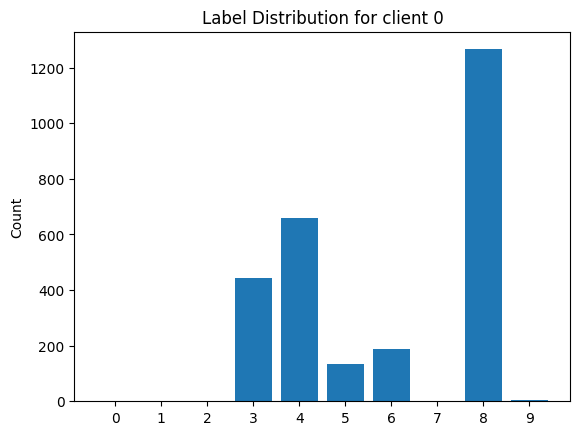

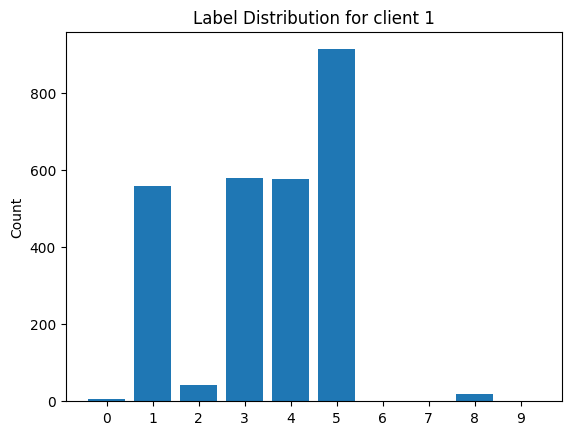

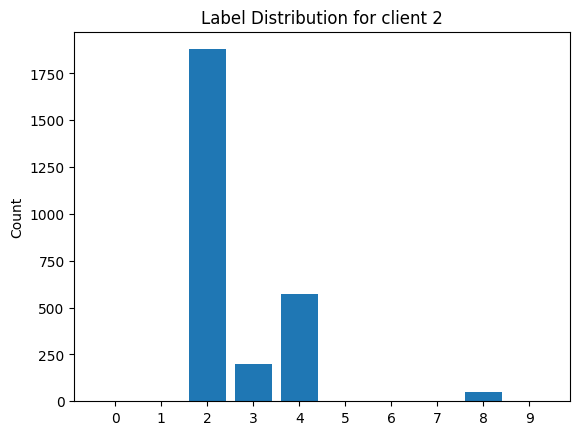

In [ ]:
def plot_label_distribution(list_loader, client_id, classes):
    loader = list_loader[client_id]
    labels = np.zeros(len(classes))  
    for images, targets in loader:
        for target in targets:
            labels[target] += 1
    plt.bar(np.arange(len(classes)), labels)
    plt.xticks(np.arange(len(classes)), classes)
    plt.ylabel('Count')
    plt.title('Label Distribution for client {0}'.format(client_id))
    plt.show()
    
plot_label_distribution(trainloaders, 0, CLASSES)
plot_label_distribution(trainloaders, 1, CLASSES)
plot_label_distribution(trainloaders, 2, CLASSES)

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

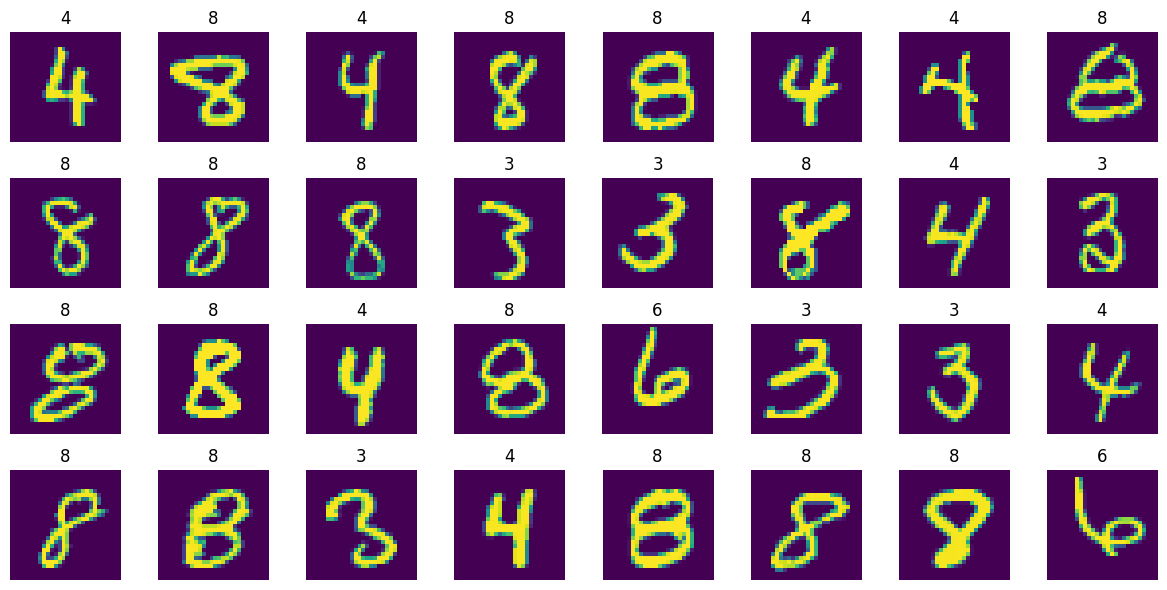

In [ ]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## Step 2: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Defining the model

We use a simple one-layer neural network, the advantage being simplicity and speed. Also, the convex function that we want to minimize is convex.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        if dataset == "MNIST":
            self.fc = nn.Linear(28 * 28, 10)
        elif dataset == "CIFAR10":
            self.fc = nn.Linear(32 * 32 * 3, 10) # 32x32x3 input features, 10 output classes
        elif dataset == "EMNIST":
            self.fc = nn.Linear(28 * 28, 47)
        
    
    def forward(self, x):
        if dataset in ["MNIST", "EMNIST"]:
            x = x.view(-1, 28 * 28) # Flatten the input
        else:
            x = x.view(-1, 32 * 32 * 3) # Flatten the input
        
        x = self.fc(x)
        return x

Let's continue with the usual training and test functions:

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(net.parameters(), lr=LR)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images).to(DEVICE)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data: 

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

In [ ]:
for epoch in range(NUM_EPOCHS):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.003131883897908954, accuracy 0.8996655518394648
Epoch 2: validation loss 0.0024656026708242485, accuracy 0.9230769230769231
Epoch 3: validation loss 0.007250012362681105, accuracy 0.7491638795986622
Epoch 4: validation loss 0.002359459432072464, accuracy 0.9264214046822743
Epoch 5: validation loss 0.007791136220147378, accuracy 0.7324414715719063
Epoch 6: validation loss 0.01078561077947202, accuracy 0.7157190635451505
Epoch 7: validation loss 0.006007187741257275, accuracy 0.8394648829431438
Epoch 8: validation loss 0.0023702883401443327, accuracy 0.9364548494983278
Epoch 9: validation loss 0.0053721021449685494, accuracy 0.8561872909698997
Epoch 10: validation loss 0.0032923733410627947, accuracy 0.9264214046822743
Epoch 11: validation loss 0.0029151109748062082, accuracy 0.9297658862876255
Epoch 12: validation loss 0.002289869813217367, accuracy 0.939799331103679
Epoch 13: validation loss 0.0022632309226288047, accuracy 0.9364548494983278
Epoch 14: validat

Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Step 3: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=NUM_LOCAL_EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [ ]:
def client_fn_FedAvg(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### How to get accuracy?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
result_fedavg = fl.simulation.start_simulation(
    client_fn=client_fn_FedAvg,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-11 09:51:36,864 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-04-11 09:51:38,071	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-11 09:51:39,264 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 7903322112.0, 'object_store_memory': 3951661056.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7903322112.0, 'object_store_memory': 3951661056.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-11 09:51:39,274 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-11 09:51:39,280 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO flwr 2023-04-11 0

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

### Plotting error and accuracy

Now, it remains to plot the logarithm excess loss and the training accuracy.

In [ ]:
def plot_metrics(list_losses, liss_accuracies, list_names):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for (loss, acc, name) in zip(list_losses, liss_accuracies, list_names):
      ax[0].plot(loss, label=name)
      ax[0].set_title('Training Loss')
      ax[0].set_xlabel('Epoch')
      ax[0].set_ylabel('Log(Train loss)')
      ax[0].set_yscale('log')
      ax[0].legend()
      ax[1].plot(acc, label=name)
      ax[1].set_title('Training Accuracy')
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Accuracy')
      ax[1].legend()
    plt.show()

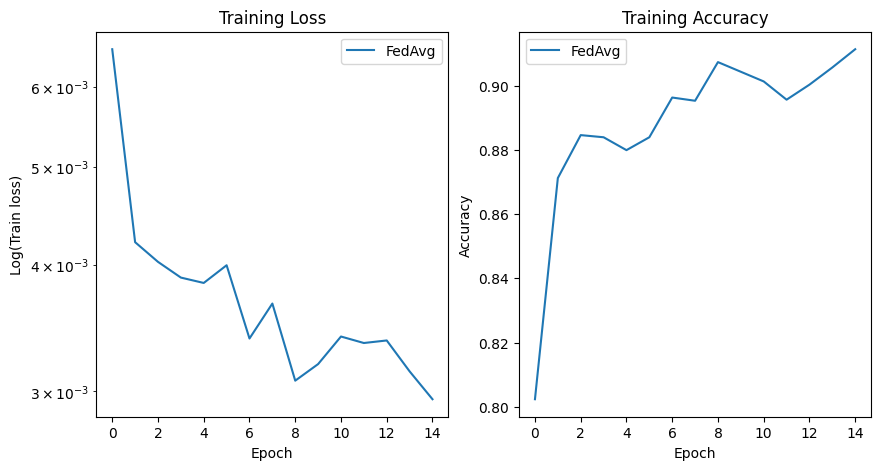

In [ ]:
losses_fedavg = [key[1] for key in result_fedavg.losses_distributed]
accuracies_fedavg = [key[1] for key in result_fedavg.metrics_distributed['accuracy']]


plot_metrics([losses_fedavg], [accuracies_fedavg], ["FedAvg"])

## Step 4: Scaffold, an algorithm to tackle heterogeneity



SCAFFOLD uses control variates (variance reduction) to correct for the ‘client drift’.

### Scaffold optimizer

In [ ]:
from torch.optim import Optimizer

class SCAFFOLDOptimizer(torch.optim.SGD):
    def __init__(self, params, lr):
        super().__init__(params, lr=lr)

    def step(self, server_control, user_control):
        loss = None

        for group in self.param_groups:
            cpt = 0
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data + server_control[cpt]- user_control[cpt]
                p.data = p.data - d_p * group['lr']
                cpt += 1
        return loss


### Implementing Flower clients adapted to Scaffold

In [ ]:
def zero_like(net) -> List[np.ndarray]:
  return [np.zeros_like(val.cpu().numpy()) for _, val in net.state_dict().items()]


In [ ]:
class FlowerClientScaffold(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

        self.local_epochs = NUM_LOCAL_EPOCHS
        self.lr = LR

    def train(self, net, server_control, control, verbose=False):
        """Train the network on the training set."""

        params_server = get_parameters(net)
        criterion = torch.nn.CrossEntropyLoss()

        optimizer = SCAFFOLDOptimizer(net.parameters(), lr=self.lr)
        net.train()
        trainloader_iter = iter(self.trainloader)

        cpt = 0
        for epoch in range(self.local_epochs):
            correct, total, epoch_loss = 0, 0, 0.0
            for images, labels in self.trainloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()

                # Scaffold step
                optimizer.step(server_control, control)
                cpt += 1

                # Metrics
                epoch_loss += loss
                total += labels.size(0)
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            epoch_loss /= len(self.trainloader.dataset)
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch + 1} on client {self.cid}: train loss {epoch_loss}, accuracy {epoch_acc}")

        params = get_parameters(net)
        delta_model = [params[j] - params_server[j] for j in range(len(params))]


        control_update = [delta_model[j] / (cpt * self.lr) for j in range(len(control))]
        new_control = [control[j] - server_control[j] - control_update[j] for j in range(len(control))]

        # Get controls differences
        delta_controls = [new_control[j] - control[j] for j in range(len(control))]

        return delta_model, delta_controls, new_control

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        server_control = config["control"]
        server_round = config["server_round"]
        try:
            control = [torch.zeros_like(p.data) for p in self.net.parameters() if p.requires_grad] if server_round == 1\
                else torch.load('control_{0}.pkl'.format(self.cid))
        except FileNotFoundError:
            control = [torch.zeros_like(p.data) for p in self.net.parameters() if p.requires_grad]
        set_parameters(self.net, parameters)
        delta_model, delta_controls, control = self.train(self.net, server_control, control)
        torch.save(control, 'control_{0}.pkl'.format(self.cid))
        return delta_model, len(self.trainloader), {"delta_controls": delta_controls}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn_Scaffold(cid: str) -> FlowerClientScaffold:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClientScaffold(cid, net, trainloader, valloader)

### Implementing the Scaffold strategy for the central server

In [ ]:
from logging import WARNING
from typing import Dict, List, Optional, Tuple
from typing import Callable, Union

from flwr.common import (FitIns, MetricsAggregationFn, Parameters, FitRes, Scalar, 
                        ndarrays_to_parameters, parameters_to_ndarrays)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate
from flwr.common.logger import log

class Scaffold(fl.server.strategy.FedAvg):
    def __init__(
        self,
        initial_parameters,
        total_nb_clients,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        global_lr: int = 1
    ) -> None:
        super().__init__(initial_parameters=initial_parameters)
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.global_lr = global_lr
        self.weights = parameters_to_ndarrays(self.initial_parameters)
        self.control = [np.zeros_like(p) for p in self.weights]
        self.total_nb_clients = total_nb_clients
        
    def __repr__(self) -> str:
        return "Scaffold"

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        delta_params = [parameters_to_ndarrays(fit_res.parameters) for _, fit_res in results]
        delta_controls = [fit_res.metrics["delta_controls"] for _, fit_res in results]

        delta_params_agg = [np.sum(np.stack([delta_params[j][k] for j in range(len(delta_params))]), axis=0)
                          for k in range(len(delta_controls[0]))]
        delta_params_lr = [self.global_lr * delta / len(delta_params) for delta in delta_params_agg]
        self.weights = [self.weights[j] + delta_params_lr[j] for j in range(len(self.weights))]

        # Updating the control variate on the central server.
        delta_controls_agg = [torch.sum(torch.stack([delta_controls[j][k] for j in range(len(delta_controls))]), dim=0)
                          for k in range(len(delta_controls[0]))]
        delta_control_weighted = [delta / self.total_nb_clients for delta in delta_controls_agg]
        self.control = [self.control[j] + delta_control_weighted[j].numpy() for j in range(len(self.control))]

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return ndarrays_to_parameters(self.weights), metrics_aggregated

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)

        # Adding the server control variate to the message that is sent to the clients
        config["control"] = self.control
        config["server_round"] = server_round
        fit_ins = FitIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, fit_ins) for client in clients]

    

### Starting the training

In [ ]:
# Create FedAvg strategy
strategy = Scaffold(
    total_nb_clients=NUM_CLIENTS,
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=5,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    initial_parameters=ndarrays_to_parameters(get_parameters(Net())),
    global_lr = 1
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
result_scaffold = fl.simulation.start_simulation(
    client_fn=client_fn_Scaffold,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-04-11 10:09:24,192 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)
2023-04-11 10:09:29,954	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-11 10:09:30,961 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 7901744334.0, 'CPU': 2.0, 'object_store_memory': 3950872166.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7901744334.0, 'CPU': 2.0, 'object_store_memory': 3950872166.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-04-11 10:09:30,973 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-11 10:09:30,981 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-04-11 10:09:30,986 | 

In [ ]:
result_scaffold

History (loss, distributed):
	round 1: 0.006892187375089396
	round 2: 0.003555816885420311
	round 3: 0.003809419902272049
	round 4: 0.0033369377554459717
	round 5: 0.0036067939771457663
	round 6: 0.0033731087693402596
	round 7: 0.0028687108420209343
	round 8: 0.003432809544048182
	round 9: 0.0030063381487111184
	round 10: 0.002844409546176327
	round 11: 0.0025948148532256633
	round 12: 0.0030904516328537344
	round 13: 0.0031587626548315764
	round 14: 0.002866662774596326
	round 15: 0.002831132615290358
History (metrics, distributed):
{'accuracy': [(1, 0.8026755852842808), (2, 0.9003344481605351), (3, 0.888294314381271), (4, 0.9026755852842808), (5, 0.8896321070234113), (6, 0.9006688963210702), (7, 0.9096989966555185), (8, 0.8993311036789299), (9, 0.9123745819397994), (10, 0.9107023411371238), (11, 0.9264214046822744), (12, 0.9127090301003344), (13, 0.9086956521739131), (14, 0.917391304347826), (15, 0.9167224080267559)]}

### Comparing to FedAvg

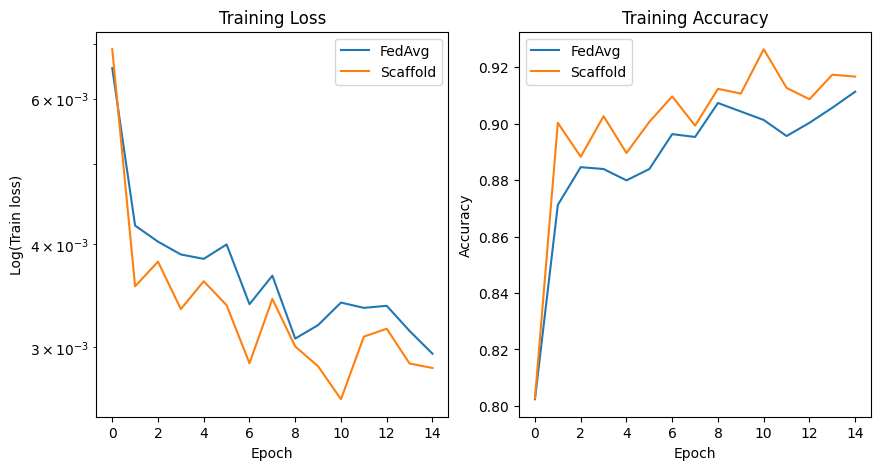

In [ ]:
losses_scaffold = [key[1] for key in result_scaffold.losses_distributed]
accuracies_scaffold = [key[1] for key in result_scaffold.metrics_distributed['accuracy']]

plot_metrics([losses_fedavg, losses_scaffold], 
             [accuracies_fedavg, accuracies_scaffold], 
             ["FedAvg", "Scaffold"])

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 20 heterogeneous clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification).


## Citing Flowers


```
@article{beutel2020flower,
  title={Flower: A Friendly Federated Learning Research Framework},
  author={Beutel, Daniel J and Topal, Taner and Mathur, Akhil and Qiu, Xinchi and Fernandez-Marques, Javier and Gao, Yan and Sani, Lorenzo and Kwing, Hei Li and Parcollet, Titouan and Gusmão, Pedro PB de and Lane, Nicholas D}, 
  journal={arXiv preprint arXiv:2007.14390},
  year={2020}
}
```

